In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock

/albedo/home/pscholz/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/options.py:93: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  FutureWarning,
/albedo/home/pscholz/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/options.py:93: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  FutureWarning,


/albedo/home/pscholz/tripyview


In [2]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [3]:
# Parameters
# mesh_path = '/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'xmoc_tseries'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'amoc'
year      = [1958,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
do_rescale= None
ncolumn   = 3 
do_allcycl= False
do_concat = False
which_dpi = 300
which_lat = 26.5 # 'max' # 'max', 26.0
which_moc = 'amoc'
do_rapid  = False
do_wbolus = True
do_compute= True
do_1flag  = True

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl is not "None") and do_1flag: 
    #__________________________________________________________________________________________________
    if do_allcycl: cycl_s=1
    else         : cycl_s=which_cycl    
    
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, which_cycl+1):
            # input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None) and (ref_path is not "None"): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, which_cycl+1):
            #ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)    
    do_1flag  = False
    
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path is not "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0 
else:
    do_reffig=False    

#______________________________________________________________________________________________________
if not isinstance(which_lat, list): which_lat = list([which_lat])        
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path is not "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = input_paths + ref_path, input_names + ref_name 
    else:    
        input_paths, input_names = input_paths + list([ref_path]), input_names + list([ref_name])
        
#______________________________________________________________________________________________________
if not isinstance(which_lat[0], float) and not isinstance(which_lat[0], int): do_rapid=False
else:    
    if np.abs(which_lat[0]-26.5)>1.0: do_rapid=False

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
 > comp. e_resol from mean
 > comp n_resol from e_resol
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


/albedo/home/pscholz/tripyview/tripyview/sub_mesh.py:903: RuntimeWarning: divide by zero encountered in true_divide
  self.n_resol=self.n_resol/self.n_area/3.0


In [5]:
zdefuc,zdeflc = [500,2000], [1500, 6000] # z-definition for upper/lower cell
zmoc_tlist    = list()
year_list     = list(range(year[0], year[1]+1))
chnk_size     = 5 # compute dmoc time-series in chunks of chnk_size years
chnk_yrs_list = year_list[::chnk_size]
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    
    print(' > year:', end='')
    ts = clock.time()
    
    # compute dmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='\n        ')
         
        #____________________________________________________________________________________________________
        # load vertical velocity 
        data = tpv.load_data_fesom2(mesh, datapath, vname='w', year=year_chnk, descript=descript , 
                                    do_info=False, do_tarithm='None', do_zarithm=None, do_nan=False, do_compute=do_compute) 
        data['w'].data = data['w'].data+tpv.load_data_fesom2(mesh, datapath, vname='bolus_w', year=year_chnk, 
                                                             do_info=False, do_tarithm='None', do_zarithm=None, 
                                                             do_nan=False, do_compute=do_compute)['bolus_w'].data

        #____________________________________________________________________________________________________
        # compute moc profile over time
        zmoc  = tpv.calc_zmoc(mesh, data, dlat=1.0, which_moc=which_moc, do_info=False, do_onelem=True)
        
        #____________________________________________________________________________________________________
        # compute time-series
        if  vname == 'ipmoc' or vname == 'pmoc':
            zmoc_tchnk = zmoc.where((zmoc['depth']>=zdeflc[0]) & (zmoc['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_aabw'})
        elif vname == 'amoc' or vname == 'aamoc':
            zmoc_nadw  = zmoc.where((zmoc['depth']>=zdefuc[0]) & (zmoc['depth']<=zdefuc[1])).max(dim='nz',skipna=True).rename({'zmoc':'zmoc_nadw'})
            zmoc_aabw  = zmoc.where((zmoc['depth']>=zdeflc[0]) & (zmoc['depth']<=zdeflc[1])).min(dim='nz',skipna=True).rename({'zmoc':'zmoc_aabw'})
            zmoc_tchnk = xr.merge([zmoc_nadw, zmoc_aabw], compat='minimal' )
            del(zmoc_aabw, zmoc_nadw)
        if nchnk==0: zmoc_t = zmoc_tchnk
        else       : zmoc_t = xr.concat([zmoc_t, zmoc_tchnk], dim='time')
        
        #____________________________________________________________________________________________________
        del(data, zmoc, zmoc_tchnk)
        
    #____________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    zmoc_tlist.append(zmoc_t)    
    del(zmoc_t)
    print(' --> elapsed time: {:3.2f}min.'.format((clock.time()-ts)/60.0))

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 > year:1958|1959|1960|1961|1962|1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972|1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982|1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992|1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002|2003|2004|2005|2006|2007
        2008|2009|2010|2011|2012|2013|2014|2015|2016|2017
        2018|2019
         --> elapsed time: 0.30min.


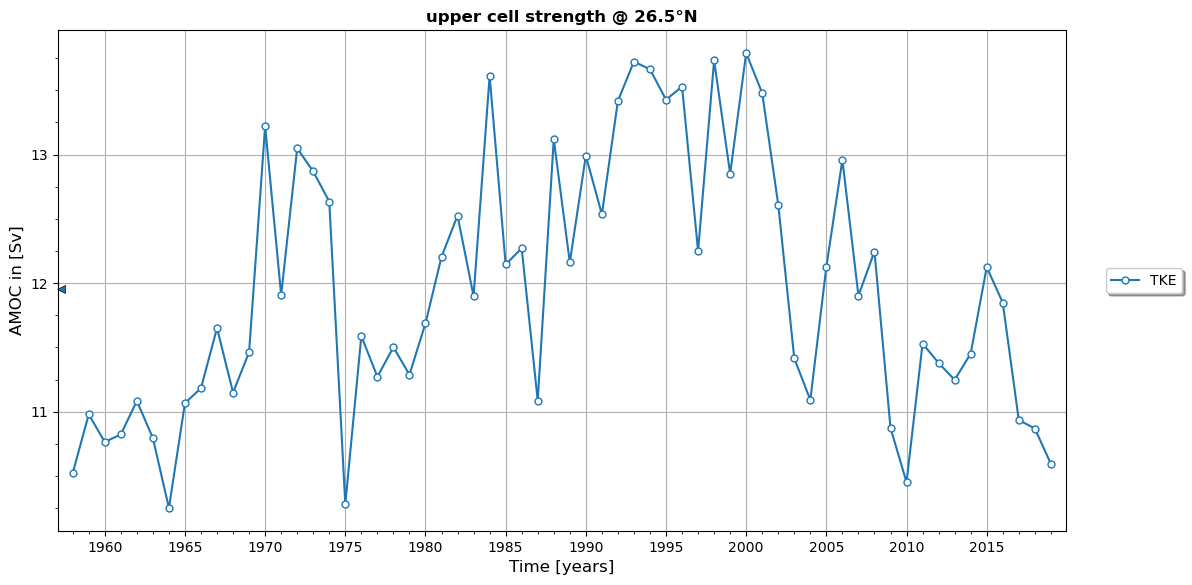

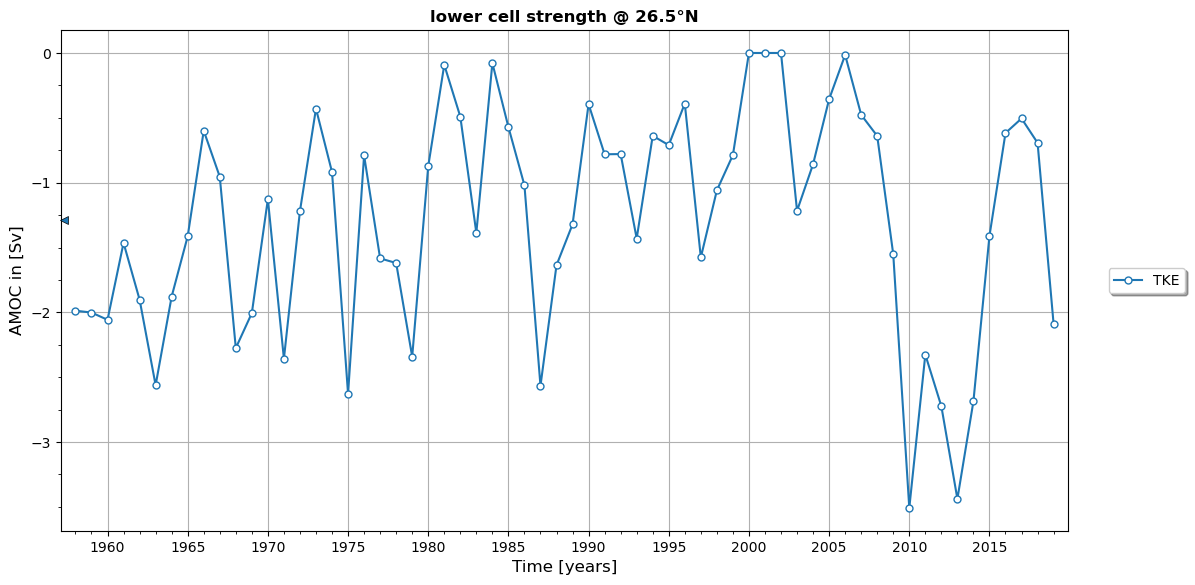

In [6]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
if spath is not None: spath  = os.path.join(spath,'{}_{}.png'.format(which_mode, sname)) 
if save_fname is not None: spath = save_fname
path_rapid = None    
if do_rapid: path_rapid=os.path.join('/home/ollie/pscholz/tripyview_github/data/data_RAPID26.5','moc_transports.nc')
fig,ax=tpv.plot_zmoc_tseries(zmoc_tlist, input_names, which_lat=which_lat, which_moc=vname, 
                              which_cycl=which_cycl, do_allcycl=do_allcycl, do_rapid=path_rapid, 
                              do_save=spath, save_dpi=which_dpi, )  